In [1]:
import os
import random

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import itertools
import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

import ben_resnet_no_batch_norm

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

### Dataset Creation

In [3]:
# Constants taken from data_helper.py
NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

# Unlabeled scenes
val_unlabeled_scene_index = np.arange(80,106)
train_unlabeled_scene_index = np.arange(80)

# Image folder
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'
first_dim = 'image'

# Option 1
CROP_SIZE = 225
PATCH_SIZE = 64

# Option 2
# CROP_SIZE = 150
# PATCH_SIZE = 32

# Add other data augmentation

# Augmentation trasnforms
aug_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(CROP_SIZE),
    torchvision.transforms.RandomApply([
        torchvision.transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
        torchvision.transforms.Grayscale(3),
#         transforms.RandomAffine(3),
    ]),
    torchvision.transforms.ToTensor(),
])
# Transforms
transform = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(CROP_SIZE),torchvision.transforms.ToTensor()])

In [4]:
# Get maximal Hamming permutations
# N is the number of permutations to return (subsample size)
# k are the permutations (k!)
# TODO: Speed up
def get_maximal_Hamming_permutation_set(N,k):
    # Generate all permutations and convert to matrix
    perms = list(itertools.permutations(range(k)))
    perms = np.array(perms).T
    
    # Get random index
    idx = np.random.randint(0, len(perms))
    
    # Counter
    i = 1
    
    # Get corresponding permutation and reshape to be 3d for broadcasting
    p = perms[:, idx].T
    p = p.reshape(i, k, -1)
    
    # Remove permutation to prevent resampling
    perms = np.concatenate((perms[:, 0:idx],perms[:, idx+1:]), axis=1)
    
    # Compute Hamming distance where resulting matrix is num_perms x num_remaining_perms
    while i <= N-1:
        print(i)
        # Compute Hamming distance
        hamming_dist = np.count_nonzero(p != perms, axis=1)
        ones = np.ones(i)
        dist = np.dot(ones, hamming_dist)
        # Get next index
        idx = np.argmax(dist)
        # Get corresponding permutation
        new_p = perms[:, idx].T
        # Reshape and append
        new_p = new_p.reshape(1, k, -1)
        p = np.append(p, new_p, axis=0)
        # Increment
        i += 1
        # Remove
        perms = np.concatenate((perms[:, 0:idx], perms[:, idx+1:]), axis=1)
    p = p.reshape(N, k).tolist()
    return p, perms

In [14]:
import pickle

PERMUTATION_LIMIT = 200
hard_permutations, remaining = get_maximal_Hamming_permutation_set(PERMUTATION_LIMIT, 9)

with open("/scratch/brs426/permutation_200_hard.pkl", "wb") as f:
    pickle.dump(hard_permutations, f)
    pickle.dump(remaining, f)
#permutations = list(itertools.permutations(range(9)))
#random_permutations = random.sample(permutations, 1000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [6]:
import pickle

with open("/scratch/brs426/permutation_200_hard.pkl", "rb") as f:
    permutations = pickle.load(f)
    remaining = pickle.load(f)

In [7]:
new_remaining = remaining.T

In [8]:
new_remaining = new_remaining.tolist()

In [9]:
extra_permutations = random.sample(new_remaining, 50)

final_permutations = permutations + extra_permutations

In [10]:
print(len(final_permutations))

250


In [11]:
# Based off of the UnlabeledDataset in data_helper.py
# Creates: grid_size x grid_size of cells that have cell_size x cell_size
# In each cell, we randomly extract a patch of patch_size x patch_size
# TODO: Make sure crop_size, grid_size, cell_size, and patch_size are compatible
# TODO: Probably need to clean up a little. Especially patch creation.
class JigsawPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, scene_index, transform, patch_size, cell_size, grid_size, permutations):
        """
        Args:
            image_folder (string): the location of the image folder
            scene_index (list): a list of scene indices for the unlabeled data 
            first_dim ({'sample', 'image'}):
                'sample' will return [batch_size, NUM_IMAGE_PER_SAMPLE, 3, H, W]
                'image' will return [batch_size, 3, H, W] and the index of the camera [0 - 5]
                    CAM_FRONT_LEFT: 0
                    CAM_FRONT: 1
                    CAM_FRONT_RIGHT: 2
                    CAM_BACK_LEFT: 3
                    CAM_BACK.jpeg: 4
                    CAM_BACK_RIGHT: 5
            transform (Transform): The function to process the image
        """

        self.image_folder = image_folder
        self.scene_index = scene_index
        self.transform = transform
        self.patch_size = patch_size
        self.cell_size = cell_size
        self.grid_size = grid_size
        assert first_dim in ['sample', 'image']
        self.first_dim = first_dim
        self.permutations = permutations
        
        # Number of examples
        self.length = self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
        
        # Differential between patch_size and grid cell size
        self.diff = self.cell_size - self.patch_size
        
        # List to store differentials to get patches from cells.
        # Set differentials so none of patches will be on the boundary
        self.x_diff = [random.randint(1, self.diff-2) for i in range(self.length)]
        self.y_diff = [random.randint(1, self.diff-2) for i in range(self.length)]
        
        # List to store the permutation for each image
        self.idx_permutations = [random.randint(0, len(self.permutations)-1) for i in range(self.length)]

    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
    
    def __getitem__(self, index):
        scene_id = self.scene_index[index // (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
        sample_id = (index % (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
        image_name = image_names[index % NUM_IMAGE_PER_SAMPLE]

        image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 
        image = Image.open(image_path)
        image = self.transform(image)
        patches = []
        diff_x = self.x_diff[index]
        diff_y = self.y_diff[index]
        permutation = self.permutations[self.idx_permutations[index]]
        # Create random patch from grid cell
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = image[:, self.cell_size*j:self.cell_size*(j+1), self.cell_size*i:self.cell_size*(i+1)]
                patch = patch[:, diff_x:diff_x+self.patch_size, diff_y:diff_y+self.patch_size]
                patches.append(patch)
        patch_tensor = torch.stack(patches)
        # Permute
        patch_tensor = patch_tensor[permutation, :, :, :]
        
        # Return patch tensor and permutation
        return patch_tensor, self.idx_permutations[index]

In [12]:
train_jigsaw = JigsawPredictionDataset(image_folder, train_unlabeled_scene_index, aug_transform, patch_size=64, cell_size=75, grid_size=3, permutations=final_permutations)
val_jigsaw = JigsawPredictionDataset(image_folder, val_unlabeled_scene_index, transform, patch_size=64, cell_size=75, grid_size=3, permutations=final_permutations)

In [13]:
jigsaw_train_loader = torch.utils.data.DataLoader(train_jigsaw, batch_size=128, shuffle=True, num_workers=4)
jigsaw_val_loader = torch.utils.data.DataLoader(val_jigsaw, batch_size=128, shuffle=True, num_workers=4)

### Model Architecture

In [14]:
# Create resnet-based model
# Resnet outputs unnormalized scores for 1000 class classification problem
# Specify any of the available ResNet models and load them in
class ResNetModel(nn.Module):
    def __init__(self, resnet, num_classes, hidden_size):
        super(ResNetModel, self).__init__()
        if resnet not in [18, 34, 50, 101, 152]:
            raise Exception("Invalid resnet size")
        self.resnet = getattr(ben_resnet_no_batch_norm, "resnet{}".format(resnet))()
        
        # Remove batchnorm layers
        self.fc1 = nn.Linear(1000, hidden_size)
        # Mutliply by 9 because we are concatenating the representations for each image together
        self.fc2 = nn.Linear(9 * hidden_size, num_classes)
    
    def forward(self, x):
        # Input x is (Batch x Number of Images x Channels x Height x Width)
        batch = x.shape[0]
        channels = x.shape[2]
        height = x.shape[3]
        width = x.shape[4]
        x = x.reshape(-1, channels, height, width)
        # Now our input is ((Batch x Number of Images) x Channels x Height x Width)
        x = F.relu(self.resnet(x))
        x = F.relu(self.fc1(x))
        # Now we need to recast to have original batch size (should double check this)
        x = x.reshape(batch, -1)
        x = self.fc2(x)
        return x

### Training Logic

In [15]:
# Train logic, return average loss over training set after each epoch
def train(model, device, train_loader, optimizer, epoch, log_file_path, log_interval = 250):
    # Set model to training mode
    model.train()
    
    # Number correct for accuracy
    num_correct = 0
    
    # Train loss
    train_loss = 0
    
    f = open(log_file_path, "a+")
    # Loop through examples
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Send data and target to device
        data, target = data.to(device), target.to(device)
        
        # Zero out optimizer
        optimizer.zero_grad()
        
        # Pass data through model
        output = model(data)
        predictions = torch.argmax(output, 1)
        num_correct += torch.sum(predictions == target).item()
        
        # Compute the loss
        loss = F.cross_entropy(output, target)
        train_loss += loss.item()
        
        # Backpropagate loss
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            f.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    
    # Average train loss
    average_train_loss = train_loss / len(train_loader)
    # Print loss (uncomment lines below once implemented)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_train_loss, num_correct, len(train_loader.dataset),
        100. * num_correct / len(train_loader.dataset)))
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_train_loss, num_correct, len(train_loader.dataset),
        100. * num_correct / len(train_loader.dataset)))
    f.close()

### Validation Logic

In [16]:
# Define test method
def test(model, device, test_loader, log_file_path):
    # Set model to evaluation mode
    model.eval()
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    f = open(log_file_path, "a+")
    # don't need autograd for eval
    with torch.no_grad():
        # Loop through data points
        for data, target in test_loader:
            pass # remove once implemented
        
            # Send data to device
            data, target = data.to(device), target.to(device)
            
            # Pass data through model
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
            
            # Get predictions from the model for each data point
            predictions = torch.argmax(output, 1)

            # Add number of correct predictions to total num_correct 
            num_correct += torch.sum(predictions == target).item()
            
    
    # Compute the average test_loss
    # avg_test_loss = TODO
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))
    f.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))
    f.close()
    
    return avg_test_loss

In [17]:
# ResNet model
res = ResNetModel(50,250, 256).to(device)

# Optimizer
optimizer = optim.Adam(res.parameters(), lr=3e-4)

In [19]:
f = "/scratch/brs426/ben_models/resnet50_no_bn_jigsaw_single_image_hard_200_permutations_50_bonus_SSL_checkpoint.log"
#best_val_loss = None
save_path = "/scratch/brs426/ben_models/resnet50_no_bn_jigsaw_single_image_hard_200_permutations_50_bonus_SSL_checkpoint.p"
epochs = 30
for epoch in range(61, 71):
    # Train model
    train(res, device, jigsaw_train_loader, optimizer, epoch, f)
    val_loss = test(res, device, jigsaw_val_loader, f)
    # Save model
    if best_val_loss is None:
        torch.save({'model_state_dict': res.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss
    elif val_loss < best_val_loss:
        torch.save({'model_state_dict': res.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss

Train Epoch: 61 [0/60480 (0%)]	Loss: 0.258276
Train Epoch: 61 [32000/60480 (53%)]	Loss: 0.261011

Train set: Average loss: 0.2526, Accuracy: 52741/60480 (87%)


Test set: Average loss: 0.2636, Accuracy: 17024/19656 (87%)

Train Epoch: 62 [0/60480 (0%)]	Loss: 0.158843
Train Epoch: 62 [32000/60480 (53%)]	Loss: 0.255008

Train set: Average loss: 0.2469, Accuracy: 52950/60480 (88%)


Test set: Average loss: 0.2602, Accuracy: 17034/19656 (87%)

Train Epoch: 63 [0/60480 (0%)]	Loss: 0.214319
Train Epoch: 63 [32000/60480 (53%)]	Loss: 0.211082

Train set: Average loss: 0.2437, Accuracy: 53000/60480 (88%)


Test set: Average loss: 0.2685, Accuracy: 17051/19656 (87%)

Train Epoch: 64 [0/60480 (0%)]	Loss: 0.293357
Train Epoch: 64 [32000/60480 (53%)]	Loss: 0.187310

Train set: Average loss: 0.2406, Accuracy: 53094/60480 (88%)


Test set: Average loss: 0.2644, Accuracy: 17018/19656 (87%)

Train Epoch: 65 [0/60480 (0%)]	Loss: 0.230741
Train Epoch: 65 [32000/60480 (53%)]	Loss: 0.224654

Train set: Ave

In [ ]:
# ResNet model
res = ResNetModel(18,200, 256).to(device)

# Optimizer
optimizer = optim.Adam(res.parameters(), lr=3e-4)

In [ ]:
best_val_loss = None
save_path = "/scratch/brs426/ben_models/resnet18_jigsaw_single_image_200_permutations_SSL_checkpoint.p"
epochs = 20
for epoch in range(1, epochs + 1):
    # Train model
    train(res, device, jigsaw_train_loader, optimizer, epoch)
    val_loss = test(res, device, jigsaw_val_loader)
    # Save model
    if best_val_loss is None:
        torch.save({'model_state_dict': res.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss

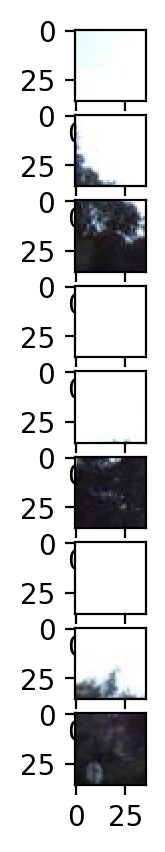

In [52]:
fig, (ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8, ax9) = plt.subplots(9,1)
ax1.imshow(patches[0].numpy().transpose(1,2,0))
ax2.imshow(patches[1].numpy().transpose(1,2,0))
ax3.imshow(patches[2].numpy().transpose(1,2,0))
ax4.imshow(patches[3].numpy().transpose(1,2,0))
ax5.imshow(patches[4].numpy().transpose(1,2,0))
ax6.imshow(patches[5].numpy().transpose(1,2,0))
ax7.imshow(patches[6].numpy().transpose(1,2,0))
ax8.imshow(patches[7].numpy().transpose(1,2,0))
ax9.imshow(patches[8].numpy().transpose(1,2,0))

In [36]:
ax1.imshow(patches[0].numpy().transpose(1,2,0))
ax2.imshow(patches[1].numpy().transpose(1,2,0))

In [36]:
old_resnet50 = models.resnet50()

In [37]:
print(old_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# How to change layer from BatchNorm2d to Identity
resnet50.bn2 = nn.Identity()

In [29]:
# How to get attribute names?
print(dir(resnet50))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_impl', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_make_layer', '_modules', '_named_members', '_norm_layer', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'avgpool', 'base_width', 'bn1', 'buffers', 'children', 'conv1', 'cpu', 'cuda', 'dilation', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc', 'float', 'forward', 'groups', '

In [23]:
res = res.to("cpu")

In [1]:
!nvidia-smi

Mon May  4 13:52:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:85:00.0 Off |                    0 |
| N/A   37C    P0   154W / 250W |   3481MiB / 16280MiB |     74%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [49]:
print(torch.__version__)

1.4.0
